In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
from pathlib import Path
import anndata as ad
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/ylu/project/spateo-release_new")
import spateo_dev as st
sys.path.insert(0, "/home/ylu/project")
from utils import *

os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

%load_ext autoreload
%autoreload 2

2024-07-14 23:11:04.541764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 23:11:04.710086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.3/lib64
2024-07-14 23:11:04.710116: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-14 23:11:05.449595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot ope

In [2]:
data_folder = "./results/split_slices_CCF/"
results_folder = "./results/Spateo_mesh/"
figures_folder = "./results/figures/Spateo_mesh"
Path(results_folder).mkdir(parents=True, exist_ok=True)

In [3]:
import re
def list_and_sort_files_by_number(directory_path, suffix):
    def extract_number(filename):
        match = re.search(r'\d+', filename)
        return int(match.group()) if match else float('inf')
    try:
        files = [f for f in os.listdir(directory_path) if f.endswith(suffix)]
        sorted_files = sorted(files, key=extract_number)
        return sorted_files
    except FileNotFoundError:
        return f"The directory {directory_path} does not exist."
    except NotADirectoryError:
        return f"The path {directory_path} is not a directory."
    except PermissionError:
        return f"Permission denied to access {directory_path}."

directory_path = data_folder
sorted_files = list_and_sort_files_by_number(directory_path, '.h5ad')

In [4]:
## load the data
from tqdm import tqdm
slices = []
for f in tqdm(sorted_files):
    slices.append(ad.read_h5ad(os.path.join(data_folder, f)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 129/129 [00:21<00:00,  6.13it/s]


In [5]:
spatial_key = "spatial_2D"
anno_key = "cell_type"

In [6]:
transformation = np.load('./results/stats_results/Spateo_global_transformation.npy', allow_pickle=True).item()
align_Rotation = transformation['align_Rotation']
align_translation = transformation['align_translation']

In [7]:
for i in range(len(slices)):
    slices[i].obsm['global_align_spatial'] = slices[i].obsm['spatial_2D'] @ align_Rotation[i].T + align_translation[i]

In [8]:
slices[0]

AnnData object with n_obs × n_vars = 12531 × 1122
    obs: 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'cluster_id_transfer', 'subclass_transfer', 'cluster_confidence_score', 'subclass_confidence_score', 'high_quality_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'z_height'
    var: 'gene_name', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_CCF', 'X_spatial_coords', 'X_umap', 'spatial_2D', 'global_align_spatial'

In [9]:
labels_list = []
for i in range(len(slices)):
    labels_list+=slices[i].obs['cell_type'].cat.categories.to_list()
labels_list = np.unique(labels_list)
palette = {labels_list[i]: sns.color_palette("Spectral", len(labels_list))[i] for i in range(len(labels_list))}

In [10]:
z_values = []
for i in range(len(slices)):
    z_values.append(np.mean(slices[i].obs['z_height']))

In [11]:
import pyvista as pv
brain_mesh = pv.read('../../data/HalfAdultMouseBrain.vtk')

In [12]:
brain_mesh_align = st.tdr.scale_model(model=brain_mesh, scale_factor=900, scale_center=None, inplace=False)
brain_mesh_align = st.tdr.rotate_model(model=brain_mesh_align, angle=(0, 180, 0), rotate_center= brain_mesh.center, inplace=False)
brain_mesh_align = st.tdr.translate_model(model=brain_mesh_align, distance=(5900, -4000, 6000), inplace=False)
brain_mesh_align = st.tdr.scale_model(model=brain_mesh_align, scale_factor=1.1, scale_center=None, inplace=False)
brain_mesh_align = st.tdr.translate_model(model=brain_mesh_align, distance=(0,0,600), inplace=False)
brain_mesh_align = st.tdr.translate_model(model=brain_mesh_align, distance=(0,70,0), inplace=False)
brain_mesh_align = st.tdr.scale_model(model=brain_mesh_align, scale_factor=1.02, scale_center=None, inplace=False)
brain_mesh_align = st.tdr.rotate_model(model=brain_mesh_align, angle=(0, 0, 180), rotate_center= brain_mesh_align.center, inplace=False)

In [13]:
z_shift_correction = st.align.z_shift_correction(
    models=slices,
    mesh=brain_mesh_align,
    spatial_key='global_align_spatial',
    key_added='global_align_spatial_z_corrected',
    z_values=z_values,
)

In [61]:
z_shift_correction.extract_contours(method='alpha', smoothing=True, window_size=3, outlier_threshold=10, alpha=0.01, n_sampling=10000)

|-----> [Extract contours of slices, method: alpha.] in progress: 100.0000%
|-----> [Extract contours of slices, method: alpha.] finished [261.3211s]


In [ ]:
contours = z_shift_correction.contours


In [66]:
for i, c in enumerate(contours):
    np.save(f'./results/contours/{i}.npy', c)

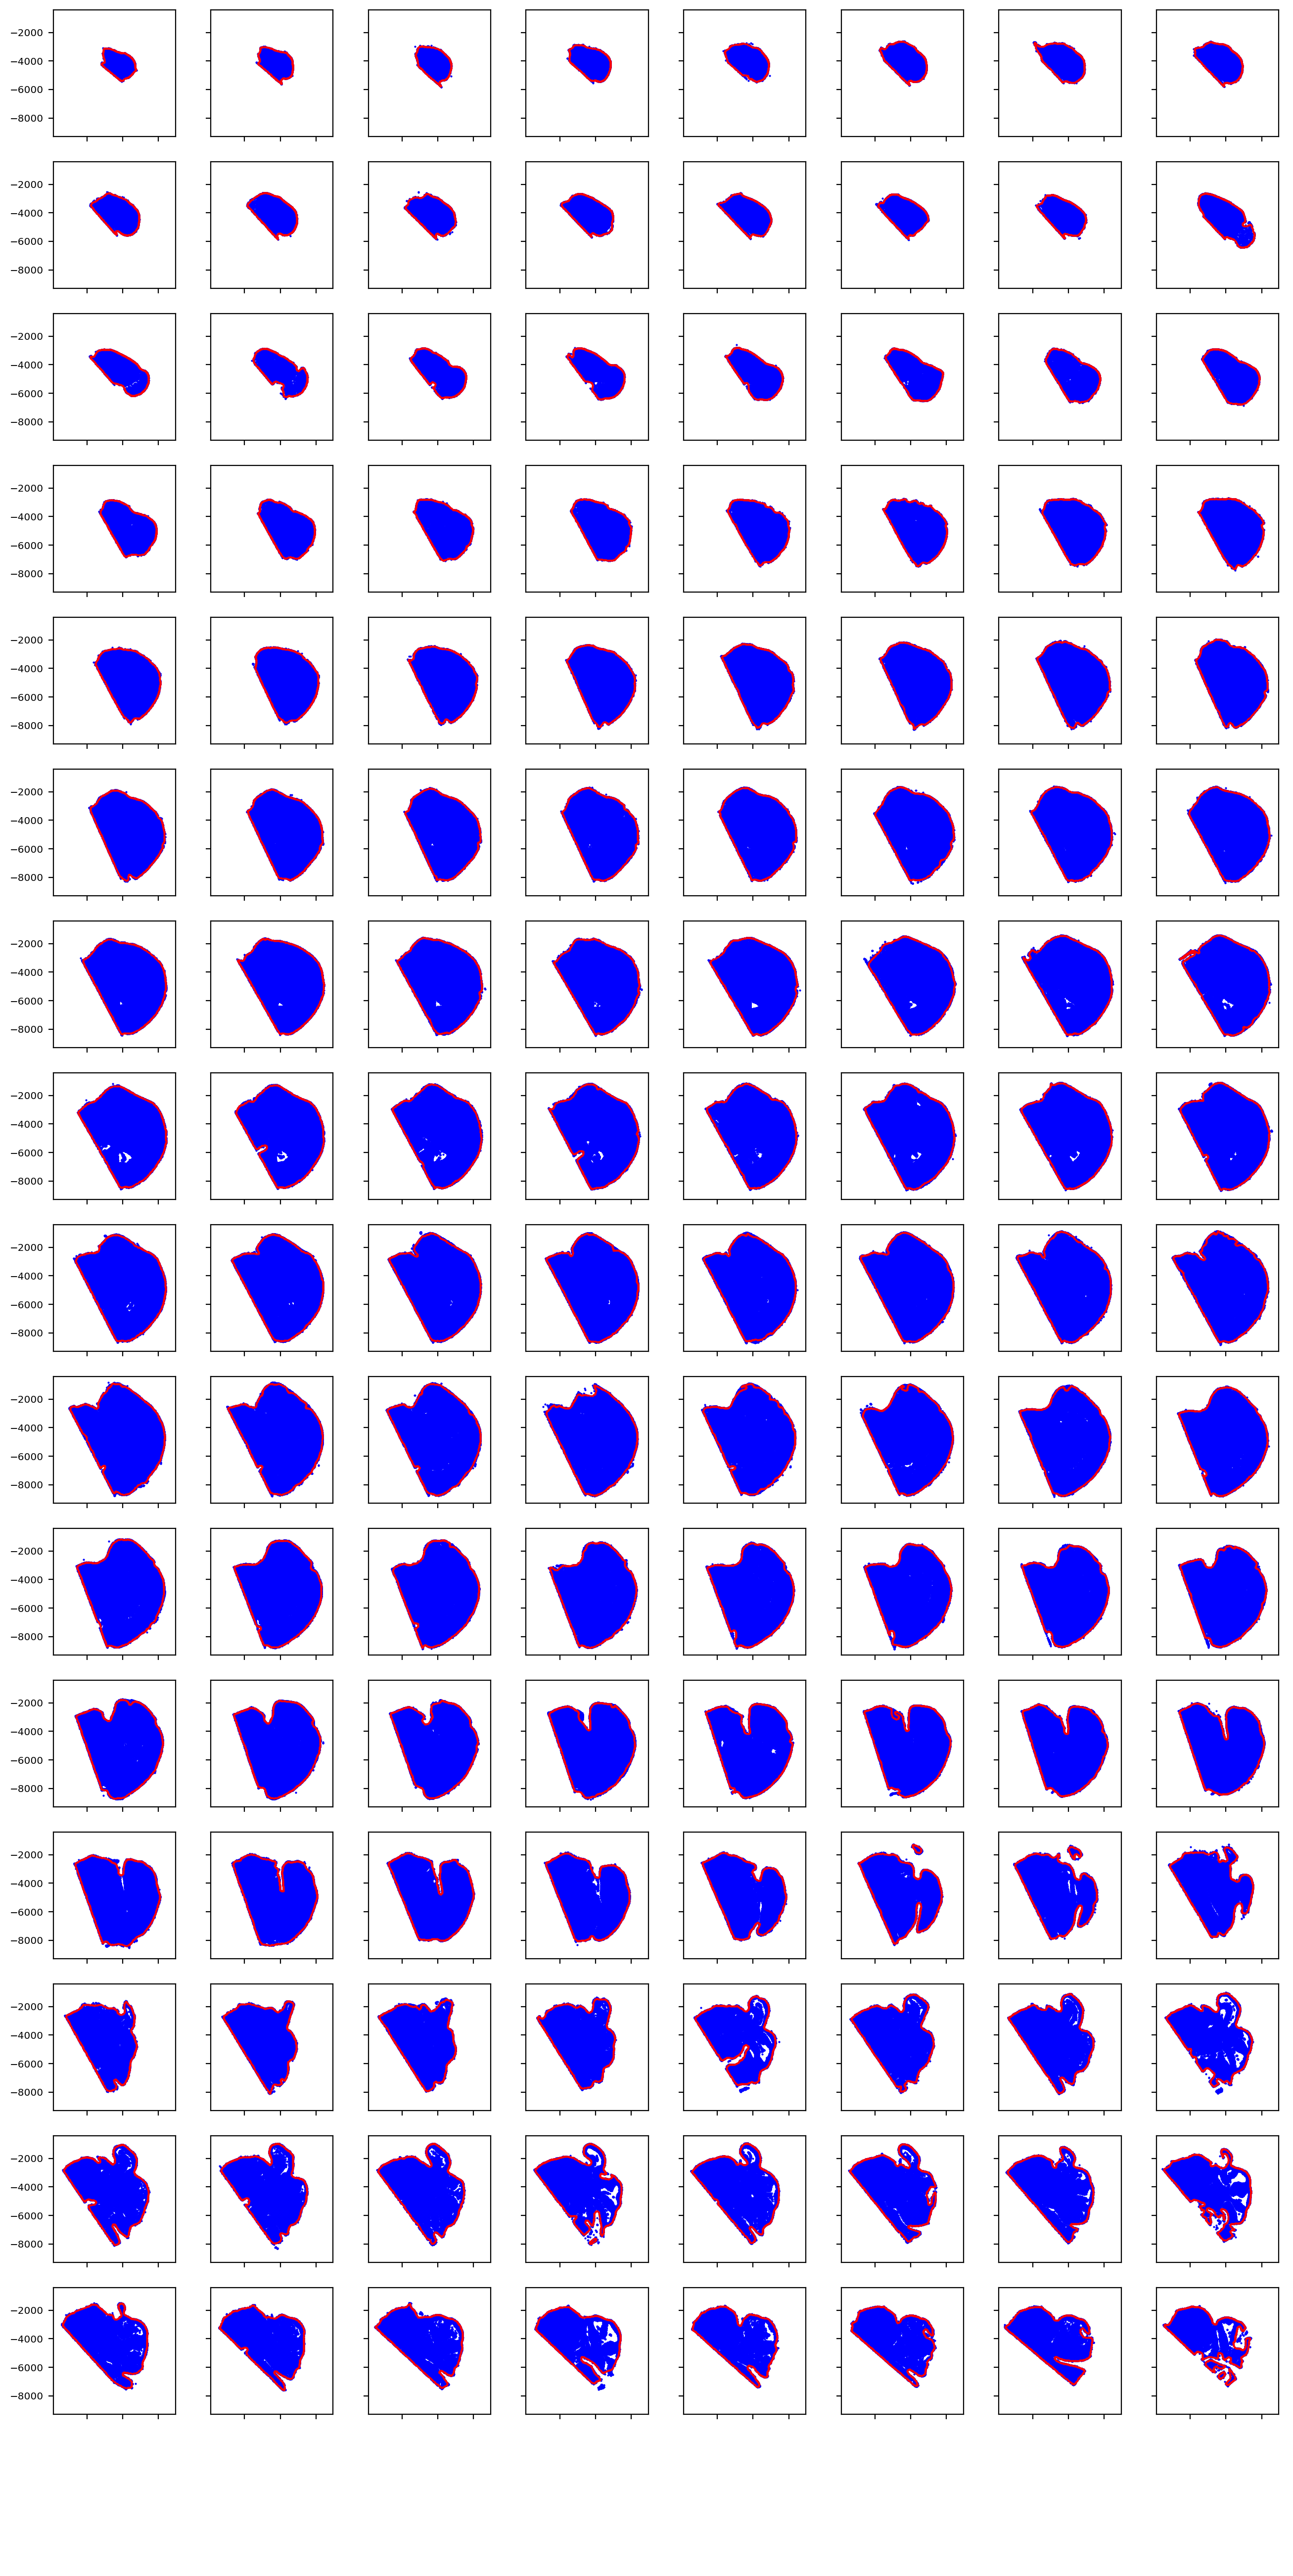

In [16]:
%matplotlib inline
spot_scatter_size = 1
col_num = 8
row_num = len(slices) // col_num + 1
fig, axs = plt.subplots(row_num, col_num, figsize = (col_num*2, row_num*2), sharex=True, sharey=True)
for i in range(col_num * row_num):
    row = i // col_num
    col = i % col_num
    ax = axs[row, col]
    if i < z_shift_correction.n_models - 1:
        points = z_shift_correction.slices_spatial[i]
        contour = z_shift_correction.contours[i]
        ax.scatter(points[:,0],points[:,1],s=spot_scatter_size, color='b')
        ax.scatter(contour[:,0],contour[:,1],s=spot_scatter_size, color='r')
        ax.set_aspect('equal')
    else:
        ax.axis('off')
# plt.savefig(os.path.join(results_folder,'GT_slices.png'), dpi=300, bbox_inches='tight')

In [ ]:
init_parameters = np.array([0,0,0,0,1])
best_parameters, _ = z_shift_correction.start_discrete_optimization(
    init_parameters=init_parameters,
    max_rotation_angle=5,
    max_translation_scale=0.1,
    max_scaling=1.05,
    labelNum=8,
    nIters=10,
    multi_process=True,
)

subsample
Current iter: 0, parameters: [0 0 0 0 1] with loss: 100000000.0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0
Current pair: 0


In [ ]:
z_shift_correction.get_z_shift(smooth=False, allow_rotation=True)

In [ ]:
z_shift_correction.z_shift_correction(
    models=slices,
)

In [ ]:
z_shift_correction.best_parameters

In [ ]:
R_shift = z_shift_correction.R_shift
z_shift = z_shift_correction.z_shift
contours = z_shift_correction.contours
z_values = z_shift_correction.z_values
z_correct_contours_3d = []
for i, (c, z) in enumerate(zip(contours, z_values)):
    c = (c - z_shift[i]) @ R_shift[i]
    z_correct_contours_3d.append(np.concatenate((c, np.ones((c.shape[0],1))*z), axis=1))

In [ ]:
pv.set_jupyter_backend('panel')
pl = pv.Plotter(notebook=True,border=True,window_size=[768,768], off_screen=False)
pl.add_mesh(pv.PolyData(z_shift_correction.aligned_mesh),color='g',point_size=1.0,render_points_as_spheres=True, ambient=0.5)

pl.add_mesh(pv.PolyData(np.concatenate(z_correct_contours_3d,axis=0)),color='r',point_size=2.0,render_points_as_spheres=True)
pl.background_color = 'k'
pl.camera_position = 'xy'
pl.show()

In [ ]:
align_Rotation = []
align_translation = []
for s in slices:
    R, t = solve_RT_by_correspondence(s.obsm['global_align_spatial_z_corrected'], s.obsm['spatial_2D'])
    align_Rotation.append(R)
    align_translation.append(t)
np.save('./results/stats_results/Spateo_mesh_transformation.npy', {'align_Rotation':align_Rotation, 'align_translation':align_translation, 'best_parameters': z_shift_correction.best_parameters}, allow_pickle=True)